<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Self-training/Self_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Fine tune Teacher model, generate pseudolabels, merge with labelled data.  Use merged data to train Student model.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import icevision

In [ ]:
from icevision.all import *

In [ ]:
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.11.0
torch v 1.10.0+cu111
torchvision v 0.11.1+cu111


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
root_dir = Path('/content/gdrive/My Drive/')

In [ ]:
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [ ]:
classes = ['Army_navy', 'Bulldog', 'Castroviejo','Forceps', 'Frazier', 'Hemostat','Iris','Mayo_metz','Needle','Potts','Richardson','Scalpel','Towel_clip', 'Weitlaner','Yankauer']
class_map = ClassMap(classes)
len(class_map)

16

In [ ]:
path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',## mayo-metz removed in vscode
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',##
    img_dir = path/'valid'
)

In [ ]:
# dataset already split in annotation tool, maintain grouping
whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

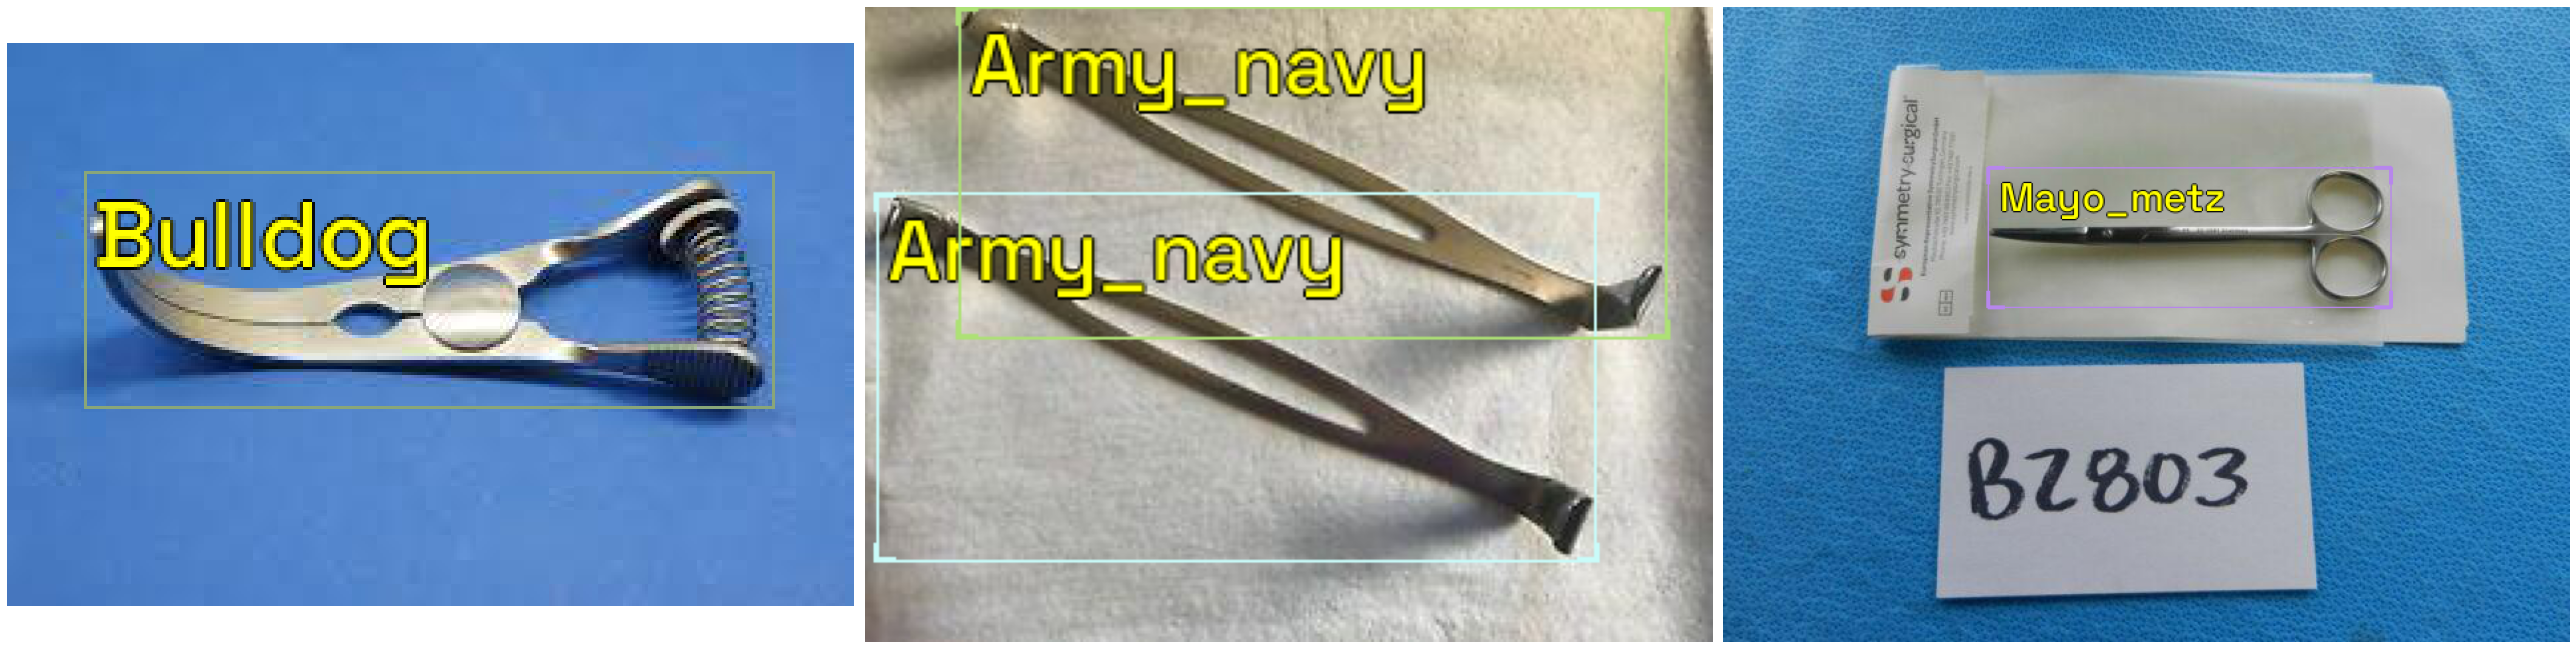

In [ ]:
show_records(train_records[3:6],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
presize = 512 ##
image_size = 384 #

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms) 
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
from icevision.models.checkpoint import *

In [ ]:
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

In [ ]:
model_type_vf = models.mmdet.vfnet #
backbone_vf_r50 = model_type_vf.backbones.resnet50_fpn_mstrain_2x(pretrained=True)#
model_vf = model_type_vf.model(backbone=backbone_vf_r50(pretrained=True), #
                      num_classes=len(class_map))

train_dl_vf = model_type_vf.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_vf = model_type_vf.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

In [ ]:
wandb.init(project = 'Surg_self_training', name = 'VFNet_teacher', ##
           reinit = True)

In [ ]:
learn_vf = model_type_vf.fastai.learner(dls = [train_dl_vf, valid_dl_vf],##
                                  model = model_vf, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.001737800776027143)

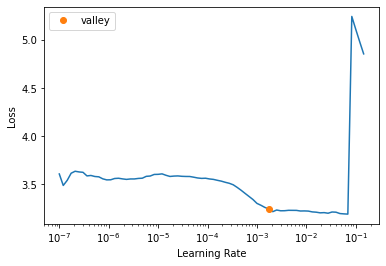

In [ ]:
learn_vf.lr_find()#

In [ ]:
learn_vf.fine_tune(100, 8e-04, freeze_epochs=1) #

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Better model found at epoch 0 with valid_loss value: 2.0959973335266113.
Could not gather input dimensions


Better model found at epoch 0 with valid_loss value: 1.6853976249694824.
Better model found at epoch 1 with valid_loss value: 1.5541905164718628.
Better model found at epoch 2 with valid_loss value: 1.5026158094406128.
Better model found at epoch 3 with valid_loss value: 1.4014980792999268.
Better model found at epoch 4 with valid_loss value: 1.3749232292175293.
Better model found at epoch 5 with valid_loss value: 1.2801265716552734.
Better model found at epoch 6 with valid_loss value: 1.276346206665039.
Better model found at epoch 8 with valid_loss value: 1.2283306121826172.
Better model found at epoch 11 with valid_loss value: 1.204551339149475.
Better model found at epoch 14 with valid_loss value: 1.190589427947998.
Better model found at epoch 20 with valid_loss value: 1.1418191194534302.
Better model found at epoch 27 with valid_loss value: 1.1285573244094849.
Better model found at epoch 29 with valid_loss value: 1.1038696765899658.


Better model found at epoch 37 with valid_loss value: 1.0843647718429565.
Better model found at epoch 42 with valid_loss value: 1.0843087434768677.
Better model found at epoch 43 with valid_loss value: 1.0631587505340576.
Better model found at epoch 51 with valid_loss value: 1.0460349321365356.
Better model found at epoch 53 with valid_loss value: 1.0007977485656738.
Better model found at epoch 59 with valid_loss value: 0.9751885533332825.
Better model found at epoch 66 with valid_loss value: 0.9440720081329346.
Better model found at epoch 73 with valid_loss value: 0.9418205618858337.


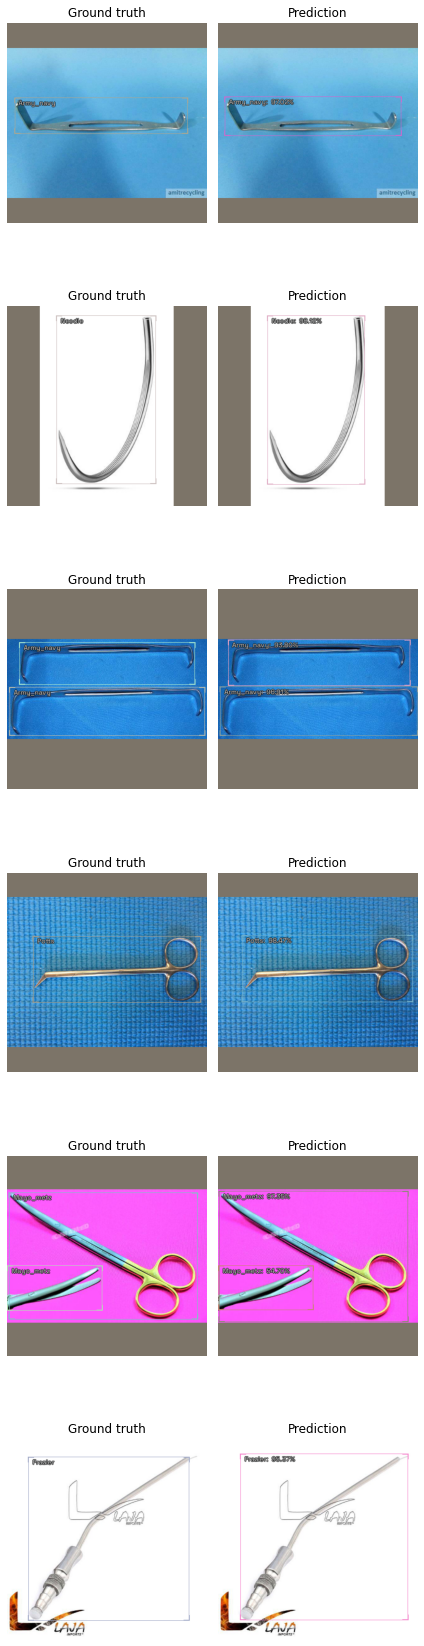

In [ ]:
model_type_vf.show_results(model_vf,##
                              valid_ds)

In [ ]:
checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_teacher_nov29_mAP82.6.pth' #100 epochs, vf

save_icevision_checkpoint(model_vf,## 
                        model_name='mmdet.vfnet', ## 
                        backbone_name='resnet50_fpn_mstrain_2x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=str(checkpoint_path), ##
                        meta={'icevision_version': '0.9.1'})

Generate pseudolabels from unlabelled set Set_U

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/

Models	Second_set.v1i.coco  Set_1_11.v2i.coco	Set_1_12.v3i.coco  Set_U


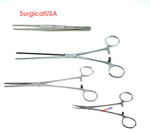

In [ ]:
image_path = Path('gdrive/MyDrive/Surgical_instruments/Set_U')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[5000]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
imgs_array = [PIL.Image.open(file) for file in img_files]
imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

In [ ]:
model_vf.eval()

In [ ]:
infer_dl = model_type_vf.infer_dl(infer_ds, 
                               batch_size=4, shuffle=False)

preds_saved_test = model_type_vf.predict_from_dl(model_vf,#
                                              infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/1378 [00:00<?, ?it/s]

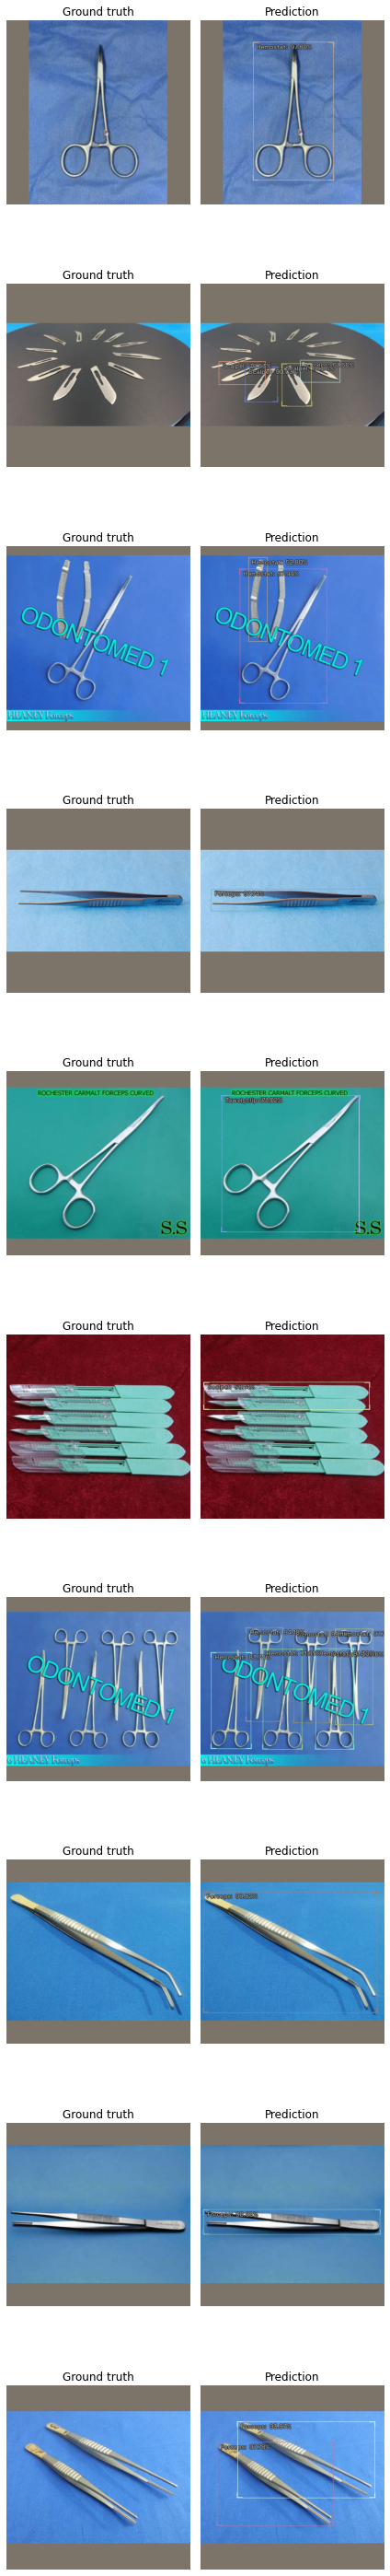

In [ ]:
show_preds(preds = preds_saved_test[0:10])
# with detection threshold 0.5

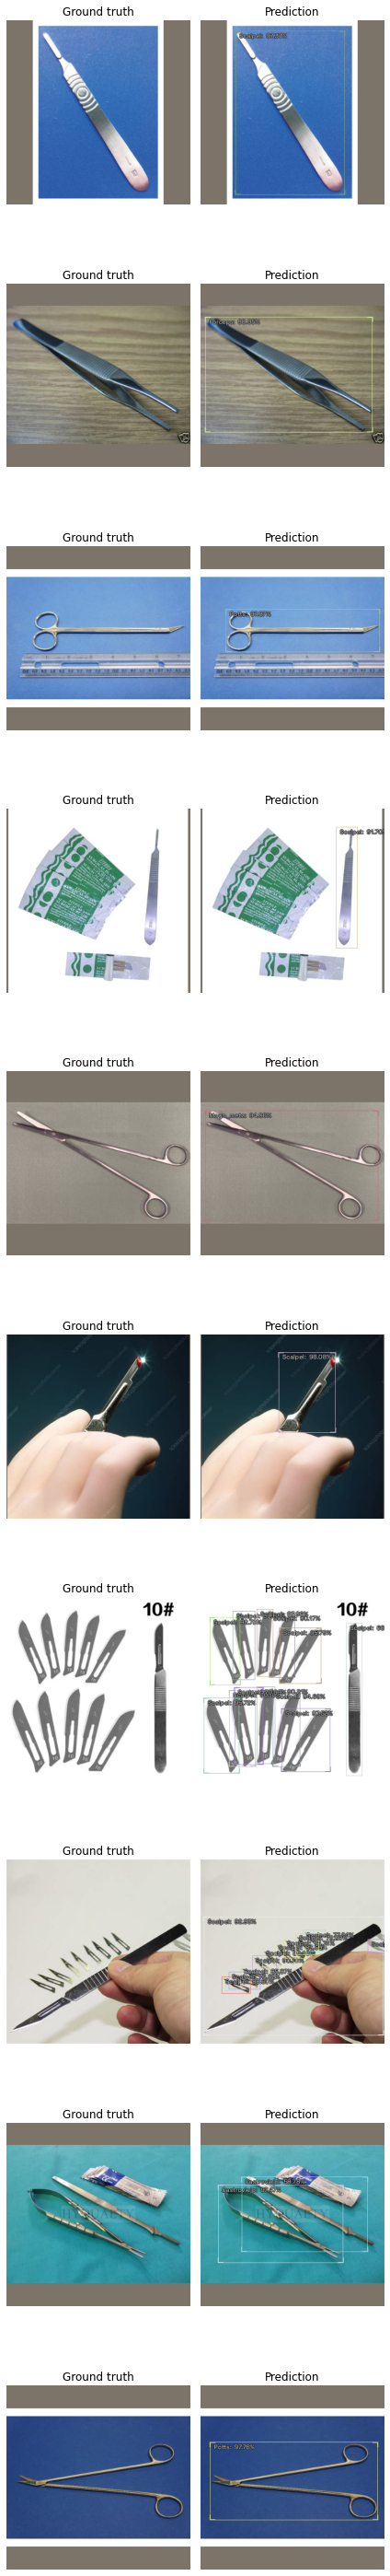

In [ ]:
show_preds(preds = preds_saved_test[10:20])

In [ ]:
for pred in preds_saved_test:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved_test)): 
  preds_saved_test[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved_test) 

In [ ]:
add_info = {
    "info": {
        "year": "2021",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2021-10-05T20:13:09+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
        "categories": [
        {
            "id": 0,
            "name": "instruments",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Army_navy",
            "supercategory": "Retractor"
        },
        {
            "id": 2,
            "name": "Bulldog",
            "supercategory": "Clamp"
        },
        {
            "id": 3,
            "name": "Castroviejo",
            "supercategory": "Needle_holder"
        },
        {
            "id": 4,
            "name": "Forceps",
            "supercategory": "Forceps"
        },
                {
            "id": 5,
            "name": "Frazier",
            "supercategory": "Suction"
        },
        {
            "id": 6,
            "name": "Hemostat",
            "supercategory": "Clamp"
        },
        {
            "id": 7,
            "name": "Iris",
            "supercategory": "Scissors"
        },
       {
            "id": 8,
            "name": "Mayo_metz",
            "supercategory": "Scissors"
        },
        {
            "id": 9,
            "name": "Needle",
            "supercategory": "Needle"
        },
        {
            "id": 10,
            "name": "Potts",
            "supercategory": "Scissors"
        },
                {
            "id": 11,
            "name": "Richardson",
            "supercategory": "Retractor"
        },
        {
            "id": 12,
            "name": "Scalpel",
            "supercategory": "Scalpel"
        },
        {
            "id": 13,
            "name": "Towel_clip",
            "supercategory": "Clamp"
        },
        {
            "id": 14,
            "name": "Weitlaner",
            "supercategory": "Retractor"
        },
        {
            "id": 15,
            "name": "Yankauer",
            "supercategory": "Suction"
        }
    ]
}

In [ ]:
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()
##  edit ' to "": annot_.json

In [ ]:
# pseudo revised, uploaded to gdrive
!ls gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco/train/_annotations.coco.json


Self-Training: Utilizing pseudolabels generated by Teacher Model to train Student Model

In [ ]:
path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco')

pseudolabelled_path = Path('gdrive/MyDrive/Surgical_instruments') ##

lab_train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/('train/_annotations.coco.json'),
    img_dir = path/'train'
)

ps_train_parser = parsers.COCOBBoxParser(
    annotations_filepath = pseudolabelled_path/'_pseudo.json', ##
    img_dir = pseudolabelled_path/'Set_U'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',
    img_dir = path/'valid'
)

In [ ]:
whole = SingleSplitSplitter()

train_records, *_ = lab_train_parser.parse(data_splitter = whole)

train_records_ps, *_ = ps_train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

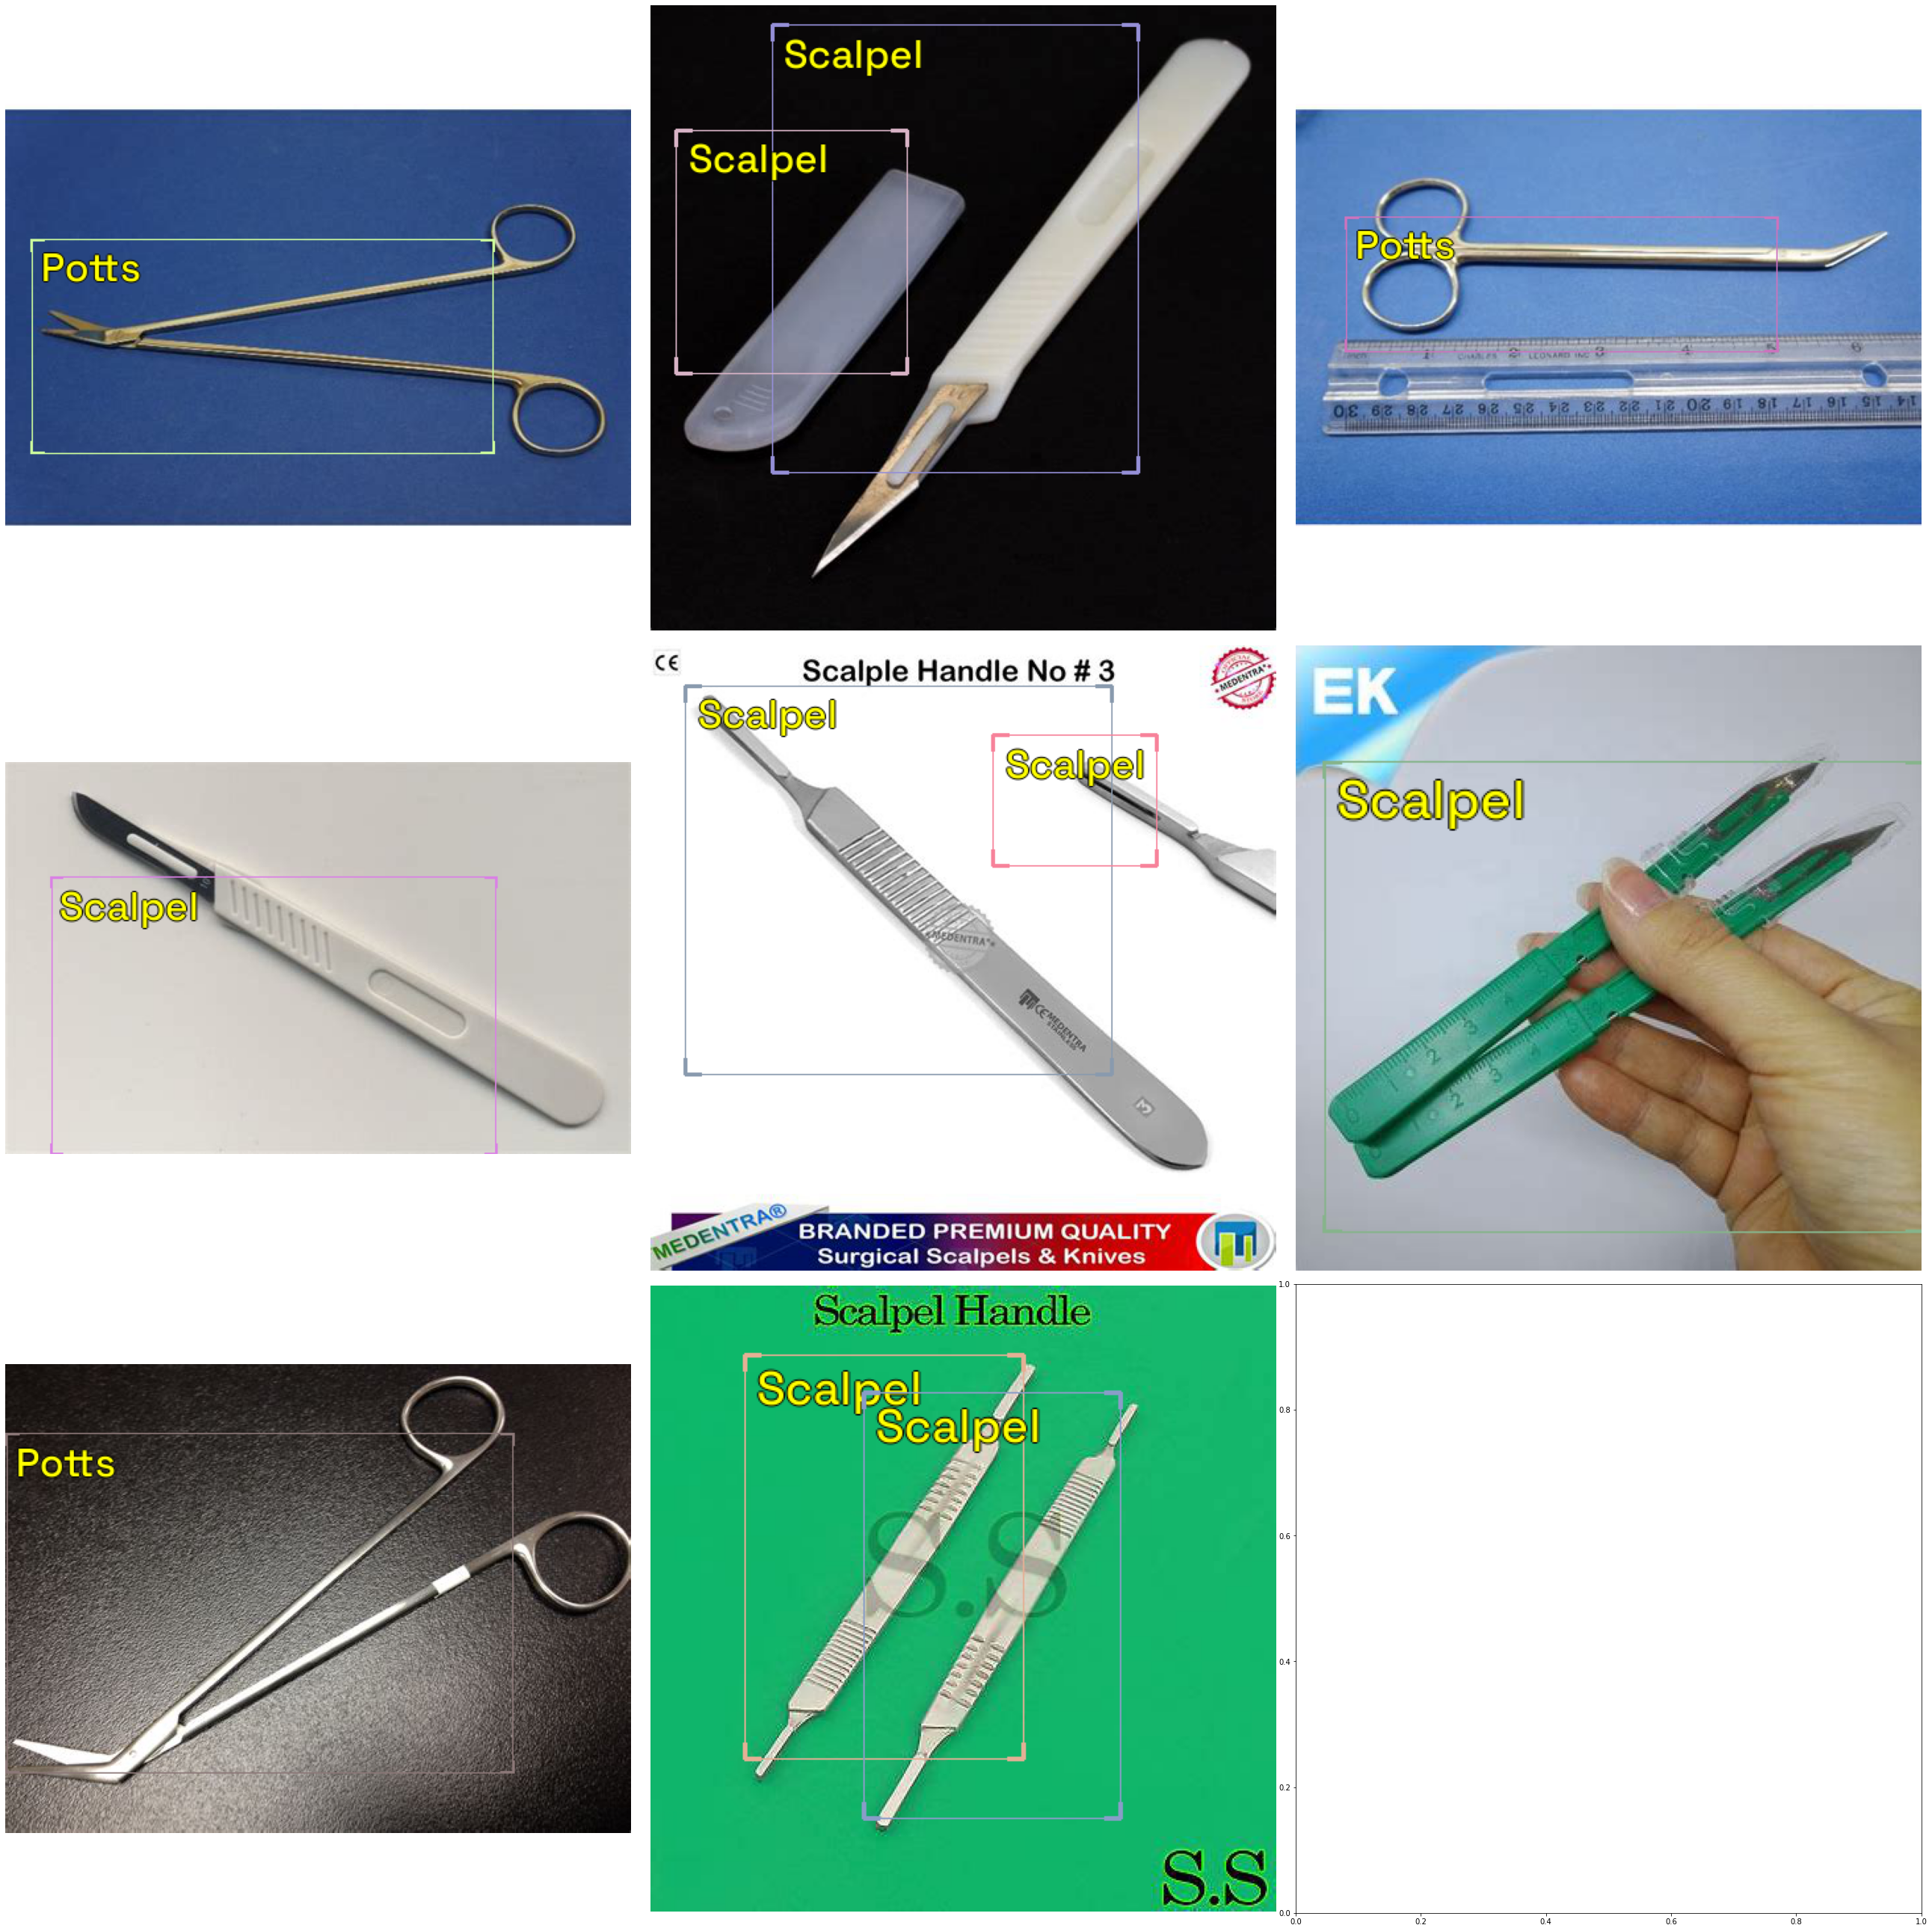

In [ ]:
show_records(train_records_ps[19:27],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
merged_train_records = torch.utils.data.ConcatDataset([train_records, train_records_ps])

In [ ]:
print(len(train_records))
print(len(train_records_ps))
print(len(merged_train_records))

1712
5458
7170


In [ ]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(merged_train_records, train_tfms) ## Second_set labelled + Set_U pseudolabels
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map),)

In [ ]:
train_dl = model_type.train_dl(train_ds, ## merged
                               batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [ ]:
wandb.init(project = 'Surg_self_training', name = 'VFNet_student', ##
           reinit = True)

In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],##
                                  model = model, ##
                                   metrics = metrics, 
                                  cbs = [WandbCallback(),#
                                  SaveModelCallback()]) #

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0003981071640737355)

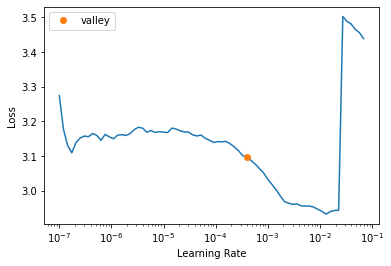

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(100, 5e-04)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: P

Better model found at epoch 0 with valid_loss value: 2.0083024501800537.
Could not gather input dimensions


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 0 with valid_loss value: 1.5998455286026.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 1 with valid_loss value: 1.5214061737060547.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 2 with valid_loss value: 1.50655996799469.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 3 with valid_loss value: 1.4617266654968262.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 4 with valid_loss value: 1.431003212928772.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Better model found at epoch 5 with valid_loss value: 1.391278624534607.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Better model found at epoch 8 with valid_loss value: 1.384962797164917.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Better model found at epoch 12 with valid_loss value: 1.3701879978179932.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Better model found at epoch 29 with valid_loss value: 1.36049485206604.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Better model found at epoch 33 with valid_loss value: 1.3539819717407227.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Better model found at epoch 39 with valid_loss value: 1.3409003019332886.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

Student training not performing well.  Training stopped.

This method of unsupervised learning does not help develop the model at this point.  

Model refinement using Supervised learning.